# Multi Agent Reinforcement Learning

While standard (single-agent) RL focuses on a _single_ agent learning to make decisions within an
environment maximizing its own cumulative reward, Multi-Agent RL (MARL) involves multiple agents
interacting within a shared environment. Each agent learns its policy, potentially influencing and
being influenced by others.

Agents might have _cooperative_ (shared reward), _competitive_ (conflicting rewards), or _mixed_
objectives, adding complexity beyond maximizing a single agent's reward.

## Key Challenges

MARL presents unique and key challenges:

- **Non-Stationarity:** The core challenge. As one agent learns and changes its policy, the
  environment effectively changes from the perspective of other agents. The learning process of
  other agents makes the environment appear dynamic and unstable to any individual agent.
- **Scalability:** The complexity (state and action spaces) can grow exponentially with the number
  of agents, making learning computationally expensive or intractable.
- **Credit Assignment:** In cooperative settings, it's difficult to determine which agent's specific
  actions contributed to the overall team success or failure, making reward distribution
  challenging.
- **Coordination/Collaboration:** Agents need to learn how to coordinate their actions effectively,
  especially with limited or no direct communication.
- **Partial Observability:** Agents often have only a limited view of the full environment state and
  may not know the internal states or intentions of other agents.

## Interesting Aspects

MARL is a very interesting setup, and deeply intertwined with **game theory**. Concepts like _Nash
Equilibrium_ (where no agent can improve its outcome by unilaterally changing its strategy) are
crucial for analyzing the stability and performance of MARL systems, especially in competitive or
mixed settings. However, finding or converging to meaningful equilibria can be difficult.

MARL systems can exhibit **complex and unexpected collective behaviors** that _emerge_ from the
interactions of individually simple agents. Studying these emergent phenomena (like flocking,
spontaneous cooperation/competition, or even simulated economic behaviors like bartering) is
fascinating and crucial for understanding system dynamics. It can also be a challenge to ensure
emergent behavior is desirable.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pettingzoo.utils.env import AgentID, AECEnv
from pettingzoo.utils import aec_to_parallel
from pettingzoo.butterfly import pistonball_v6
from pettingzoo.mpe import simple_adversary_v3

import supersuit as ss

from collections import deque
from typing import Type

from util.gymnastics import DEVICE, pettingzoo_simulation, init_random
from util.rl_algos import soft_update_model_params

## MPE Simple Adversary Environment

Let's use the [Simple Adversary environment](https://mpe2.farama.org/environments/simple_adversary/)
to train our MARL agents. This environment is a mixed competitive-cooperative environment, where the
two good agents need to deceive the adversary.

"_Good agents are rewarded based on how close the closest one of them is to the target landmark, but
negatively rewarded based on how close the adversary is to the target landmark. The adversary is
rewarded based on distance to the target, but it doesn’t know which landmark is the target landmark.
[...] This means good agents have to learn to ‘split up’ and cover all landmarks to deceive the
adversary._"


In [ ]:
# Environment configuration tuned for conveniency of this notebook.
MPE_SIMPLE_ADVERSARY_KWARGS = {
    "continuous_actions": True,
    "dynamic_rescaling": True,
}


def simple_adversary_v3_wrappers(zoo_env):
    """Configure wrappers on the simple adversary environment. In particular, make sure the
    observations of the good agents and the adversary have the same dimension."""
    zoo_env = ss.pad_observations_v0(zoo_env)
    return zoo_env


def create_simple_adversary_env():
    """Convenient function to setup the simple adversary environment."""
    env = simple_adversary_v3.env(**MPE_SIMPLE_ADVERSARY_KWARGS)
    env = simple_adversary_v3_wrappers(env)
    return env

In [3]:
test_env: AECEnv = create_simple_adversary_env()
test_env.reset(seed=42)
agents: list[AgentID] = test_env.agents
print(agents)
print(test_env.action_space(agents[0]))
print(test_env.observation_space(agents[0]))

['adversary_0', 'agent_0', 'agent_1']
Box(0.0, 1.0, (5,), float32)
Box(-inf, inf, (10,), float32)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (700, 700) to (704, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MoviePy - Building file /tmp/rl-video.gif with imageio.


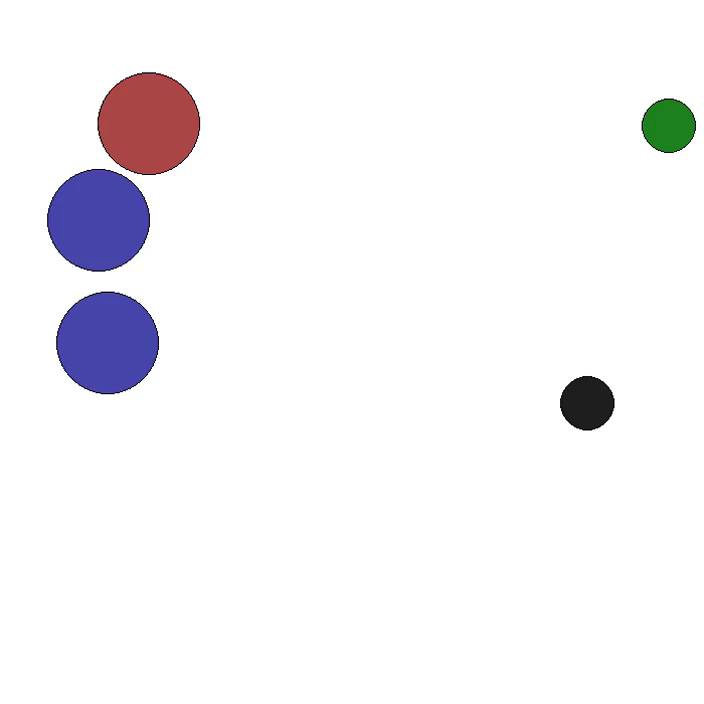

In [ ]:
pettingzoo_simulation(
    simple_adversary_v3, wrappers=[simple_adversary_v3_wrappers], **MPE_SIMPLE_ADVERSARY_KWARGS
)

## MA-DDPG

MA-DDPG is a popular algorithm for multi-agent reinforcement learning, particularly effective in
scenarios with continuous action spaces. It extends the single-agent DDPG algorithm using the
**Centralized Training with Decentralized Execution (CTDE)** paradigm.

<div>
  <img src="../assets/09_MARL_CTDE.png">
  <br>
  <small>From "Multi-Agent Actor-Critic for Mixe Cooperative-Competitive Environments"</small>
</div>

During training, a centralized controller might access all agents' observations, actions, and reward
functions to ease learning (addressing non-stationarity and credit assignment). However, during
execution, each agent acts based only on its own local observations, making the policies deployable
in real-world scenarios where centralization isn't feasible.

MA-DDPG trains a centralized critic that considers all agents' observations and actions to guide the
learning of individual actors, each of which determines a single agent's policy based only on its
local observation.

Take a look at the [paper](https://arxiv.org/abs/1706.02275)!


### Replay Buffer

Like DDPG, we use a replay buffer to store experiences. This time configured for multiple agents.


In [ ]:
class ReplayBuffer:
    """Replay buffer used in the MA-DDPG implementation.

    Stores tuples like: (obs, actions, rewards, next_obs, dones)
    """

    def __init__(self, size: int, sample_size: int, num_agents: int):
        self.size = size
        self.deque = deque(maxlen=self.size)
        self.sample_size = sample_size
        self.num_agents = num_agents

    def push(self, transition: tuple[torch.Tensor]):
        assert len(transition) == 5
        for t in transition:
            assert len(t.shape) > 1
            assert t.shape[0] == self.num_agents
        self.deque.append(transition)

    def sample(self) -> tuple[torch.Tensor]:
        samples = random.sample(self.deque, self.sample_size)

        obs = torch.stack([x[0] for x in samples]).float()
        actions = torch.stack([x[1] for x in samples]).float()
        rewards = torch.stack([x[2] for x in samples]).float()
        next_obs = torch.stack([x[3] for x in samples]).float()
        dones = torch.stack([x[4] for x in samples]).int()

        t_samples = (obs, actions, rewards, next_obs, dones)
        return tuple(x.transpose(0, 1) for x in t_samples)  # (num_agents, batch_size, ...)

    def __len__(self):
        return len(self.deque)

### Simple Adversary Neural Networks

Configure actor and critic networks, as well as an `AgentNetwork` grouping together actor, critic,
and corresponding target networks.


In [ ]:
HIDDEN_DIM = 256


class MpeActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.sigmoid(self.fc3(x))


class MpeCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, num_agents):
        super().__init__()
        self.critic_input_size = (state_dim + action_dim) * num_agents
        self.fc1 = nn.Linear(self.critic_input_size, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, 1)

    def forward(self, obs_all_agents, actions_all_agents):
        x = torch.cat((obs_all_agents, actions_all_agents), dim=2).float().to(DEVICE)
        x = x.permute(1, 0, 2).flatten(1, 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class AgentNetwork(nn.Module):
    """Convenient network to encapsulate both actor, critic, and target networks for an agent."""

    def __init__(
        self,
        num_agents,
        state_dim,
        action_dim,
        actor_net: Type[nn.Module],
        critic_net: Type[nn.Module],
        lr_actor=1e-4,
        lr_critic=1e-3,
    ):
        super().__init__()
        self.action_dim = action_dim
        self.num_agents = num_agents

        # Actor network
        self.actor = actor_net(state_dim, action_dim).to(DEVICE)
        self.actor_target = actor_net(state_dim, action_dim).to(DEVICE)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_target.eval()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor, eps=1e-5)

        # Critic network
        self.critic = critic_net(state_dim, action_dim, num_agents).to(DEVICE)
        self.critic_target = critic_net(state_dim, action_dim, num_agents).to(DEVICE)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_target.eval()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic, eps=1e-5)

### MA-DDPG Agent

MA-DDPG implementation which resembles the one described in the original paper. The actor / critic
networks are generic, so that we can plug in different architecture for different environments (see
`Pistonball` below).


In [ ]:
class MA_DDPG:
    def __init__(
        self,
        actor_net: Type[nn.Module],
        critic_net: Type[nn.Module],
        agent_ids,
        state_dim,
        action_dim,
        action_min=-1,
        action_max=1,
        gamma=0.99,
        min_buffer_size=2048,
        buffer_len=int(1e5),
        batch_size=128,
        update_every=8,
        n_updates=4,
        update_policy_every=2,
        noise_start=1.0,
        noise_reduction=0.99995,
        noise_min=0.25,
        max_grad_norm=0.5,
        lr_actor=1e-4,
        lr_critic=1e-3,
        tau=0.01,
    ):
        self.num_agents = len(agent_ids)
        self.agent_id_map = {id: index for (index, id) in enumerate(agent_ids)}
        self.agent_index_map = {index: id for (index, id) in enumerate(agent_ids)}
        self.action_dim = action_dim
        self.action_min = action_min
        self.action_max = action_max
        self.gamma = gamma
        self.noise = noise_start
        self.noise_reduction = noise_reduction
        self.noise_min = noise_min
        self.batch_size = batch_size
        self.min_buffer_size = min_buffer_size
        self.n_updates = n_updates
        self.update_every = update_every
        self.update_policy_every = update_policy_every
        self.max_grad_norm = max_grad_norm
        self.tau = tau
        self.t_step = 0

        self.replay_buffer = ReplayBuffer(buffer_len, batch_size, self.num_agents)

        self.agents = []
        for _ in range(self.num_agents):
            agent = AgentNetwork(
                self.num_agents,
                state_dim,
                action_dim,
                actor_net,
                critic_net,
                lr_actor,
                lr_critic,
            )
            self.agents.append(agent)

    def step(self, obs, actions, next_obs, rewards, dones):
        convert = lambda t: [t[self.agent_index_map[i]] for i in range(self.num_agents)]

        obs_t = torch.tensor(np.array(convert(obs)), dtype=torch.float32)
        actions_t = torch.tensor(np.array(convert(actions)), dtype=torch.float32)
        next_obs_t = torch.tensor(np.array(convert(next_obs)), dtype=torch.float32)
        rewards_t = torch.tensor(np.array(convert(rewards)), dtype=torch.float32).unsqueeze(1)
        dones_t = torch.tensor(np.array(convert(dones)), dtype=torch.uint8).unsqueeze(1)

        transition = (obs_t, actions_t, rewards_t, next_obs_t, dones_t)
        self.replay_buffer.push(transition)
        self.t_step += 1

        if len(self.replay_buffer) > self.min_buffer_size and self.t_step % self.update_every == 0:
            self.noise = max(self.noise * self.noise_reduction, self.noise_min)
            for cycle in range(self.n_updates):
                print(f"Learning cycle {cycle+1}/{self.n_updates}...".ljust(100), end="\r")
                samples = self.replay_buffer.sample()
                obs, actions, rewards, next_obs, dones = (x.to(DEVICE) for x in samples)
                for a_i in range(len(self.agents)):
                    self.learn_critic(a_i, obs, actions, rewards, next_obs, dones)
                    if self.is_actor_update():
                        self.learn_actor(a_i, obs)
            self.update_targets()

    def learn_actor(self, agent_number: int, obs):
        agent = self.agents[agent_number]
        actions_pred = [
            (self.agents[i].actor(ob) if i == agent_number else self.agents[i].actor(ob).detach())
            for i, ob in enumerate(obs)
        ]
        actor_loss = -agent.critic(obs, torch.stack(actions_pred)).mean()

        agent.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), self.max_grad_norm)
        agent.actor_optimizer.step()

    def learn_critic(self, agent_number: int, obs, actions, rewards, next_obs, dones):
        agent = self.agents[agent_number]
        with torch.no_grad():
            actions_next = [agent.actor_target(nobs) for agent, nobs in zip(self.agents, next_obs)]
            Q_targets_next = agent.critic_target(next_obs, torch.stack(actions_next))
            Q_targets = rewards[agent_number] + self.gamma * Q_targets_next * (
                1 - dones[agent_number]
            )

        Q_expected = agent.critic(obs, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets.detach())

        agent.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), self.max_grad_norm)
        agent.critic_optimizer.step()

    def update_targets(self):
        for agent in self.agents:
            soft_update_model_params(agent.critic, agent.critic_target, self.tau)
            if self.is_actor_update():
                soft_update_model_params(agent.actor, agent.actor_target, self.tau)

    @torch.no_grad()
    def eval_act(self, agent_id: AgentID, obs: np.ndarray, add_noise=False):
        obs_t = torch.from_numpy(obs).float().unsqueeze(0).to(DEVICE)
        agent_number = self.agent_id_map[agent_id]
        agent = self.agents[agent_number]

        action = agent.actor(obs_t)

        if add_noise:
            action += self.get_noise()

        action = action.squeeze(dim=0).detach().cpu().numpy()

        return np.clip(action, self.action_min, self.action_max)

    def is_actor_update(self) -> bool:
        return self.t_step % (self.update_every * self.update_policy_every) == 0

    def get_noise(self) -> torch.Tensor:
        return torch.Tensor(np.random.normal(size=self.action_dim) * self.noise).to(DEVICE)

### Training Loop

MA-DDPG training loop. It expects a PettingZoo [AECEnv](https://pettingzoo.farama.org/api/aec/) but
converts it into [parallel](https://pettingzoo.farama.org/api/parallel/) right away for convenience
of training this notebook MA-DDPG algorithm implementation.


In [ ]:
def train_maddpg(aec_env: AECEnv, agent: MA_DDPG = None, max_episodes=15_000):
    env = aec_to_parallel(aec_env)

    returns = []
    timestep = 0
    env_agent_ids = aec_env.agents

    print(f"Training started. Collecting initial experiences...".ljust(100), end="\r")
    for n_episode in range(1, max_episodes + 1):
        episode_returns = {agent_id: 0.0 for agent_id in env_agent_ids}
        obs, _ = env.reset()

        while env.agents:
            actions = {
                agent_id: (
                    agent.eval_act(agent_id, obs[agent_id], add_noise=True)
                    if agent is not None
                    else env.action_space(agent_id).sample()
                )
                for agent_id in env.agents
            }

            next_obs, rewards, terms, truncs, _ = env.step(actions)

            dones = {
                agent_id: term or trunc
                for (agent_id, term, trunc) in zip(terms.keys(), terms.values(), truncs.values())
            }

            agent.step(obs, actions, next_obs, rewards, dones)

            obs = next_obs  # Easy to overlook!

            timestep += 1
            for agent_id in env_agent_ids:
                episode_returns[agent_id] += rewards[agent_id]

        returns.append(episode_returns)

        if n_episode % 25 == 0:
            last_100_returns = returns[-100:]
            avg_returns_by_agent = {id: 0.0 for id in env_agent_ids}
            for ret in last_100_returns:
                for id in env_agent_ids:
                    avg_returns_by_agent[id] += ret[id]
            avg_returns_by_agent = {
                key: value / len(last_100_returns) for key, value in avg_returns_by_agent.items()
            }
            avg_return = np.mean([v for v in avg_returns_by_agent.values()])
            formatted_returns = (
                "{"
                + ", ".join(f"{repr(k)}: {v:.3f}" for k, v in avg_returns_by_agent.items())
                + "}"
            )
            print(f"[Episode {n_episode} AVG: {avg_return:.3f}] {formatted_returns}".ljust(100))

    print(f"Episode {n_episode} terminating training, average reward: {avg_return:.3f}".ljust(100))
    return returns

## Train Simple Adversary

We can train the `simple_adversary_v3` environment with MA-DDPG and obtain policies that show good
agents trying to trick the adversary and the adversary trying to become smarter. MA-DDPG has various
limitations, some already notable with this MPE environment:

- **Sensitivity to hyperparameters:** Finding the right learning rates, exploration parameters, and
  network architectures often requires extensive tuning.
- **Emergent Unwanted Behaviors:** Agents might learn suboptimal or even adversarial strategies that
  exploit the weaknesses of other agents or the environment, even if these behaviors weren't
  explicitly intended, landing in suboptimal policies. Sometimes early stopping is used.
- **Scalability Issues:** As the number of agents increases, the size of the joint
  action-observation space grows exponentially, making it computationally expensive and sample
  inefficient to learn joint policies. We can see this in the _Pistonball_ environment below.


In [ ]:
def plot_agent_returns(episode_returns):
    """Convenient function to plot agents and rolling average returns."""
    df = pd.DataFrame(episode_returns)
    agent_ids = df.columns.tolist()
    window_size = 100

    for agent_id in agent_ids:
        df[f"{agent_id}_running_avg"] = (
            df[agent_id].rolling(window=window_size, min_periods=1).mean()
        )
    df["overall_average_return"] = df[agent_ids].mean(axis=1)
    df["running_overall_average_return"] = (
        df["overall_average_return"].rolling(window=window_size, min_periods=1).mean()
    )

    plt.figure(figsize=(10, 3.7))
    colors = cm.get_cmap("tab10", len(agent_ids))
    for i, agent_id in enumerate(agent_ids):
        agent_color = colors(i)
        plt.plot(
            df.index,
            df[agent_id],
            label=f"{agent_id} Raw Return",
            alpha=0.3,
            color=agent_color,
            linestyle=":",
        )
        plt.plot(
            df.index,
            df[f"{agent_id}_running_avg"],
            label=f"{agent_id} Running Avg",
            color=agent_color,
            linewidth=1.5,
        )
    plt.plot(
        df.index,
        df["running_overall_average_return"],
        label="Running Avg (All Agents)",
        color="black",
        linewidth=2.5,
        linestyle="--",
    )

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Agent Returns: Raw, Individual Running Averages, and Overall Running Average")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

### Basic learning

With `~7k` episodes and a first set of hyperparameters, we see the agents trying to distance the
adversary when it gets too close to the target.

NOTE: I didn't spend too much time in configuring the hyperparameters and/or tailor the MA-DDPG
implementation to this MPE environment (e.g., using the
[Ornstein Uhlenbeck noise](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) as in
the original paper). Hence, it is very possible that we can train this environment much faster.


In [ ]:
ad_env: AECEnv = create_simple_adversary_env()
ad_env = init_random(ad_env)
agent_ids = ad_env.possible_agents
state_dim = ad_env.observation_space(agent_ids[0]).shape[0]
action_dim = ad_env.action_space(agent_ids[0]).shape[0]

agent_adv_basic = MA_DDPG(
    MpeActorNetwork,
    MpeCriticNetwork,
    agent_ids,
    state_dim,
    action_dim,
    action_min=0,
    gamma=0.995,
    min_buffer_size=2048,
    buffer_len=int(3e5),
    batch_size=128,
    update_every=50,
    n_updates=8,
    update_policy_every=4,
    noise_start=0.5,
    noise_reduction=0.99995,
    noise_min=0.1,
    lr_actor=5e-5,
    lr_critic=5e-4,
    max_grad_norm=0.1,
    tau=1e-3,
)

In [ ]:
# 25m training on GPU. Consider running on CPU given that CPU/GPU communication is bottleneck.
adv_scores_basic = train_maddpg(ad_env, agent_adv_basic, max_episodes=7_500)

[Episode 25 AVG: -3.405] {'adversary_0': -26.156, 'agent_0': 7.971, 'agent_1': 7.971}               
[Episode 50 AVG: -3.498] {'adversary_0': -26.814, 'agent_0': 8.160, 'agent_1': 8.160}               
[Episode 75 AVG: -3.568] {'adversary_0': -26.986, 'agent_0': 8.141, 'agent_1': 8.141}               
[Episode 100 AVG: -3.044] {'adversary_0': -26.954, 'agent_0': 8.911, 'agent_1': 8.911}              
[Episode 125 AVG: -2.532] {'adversary_0': -28.611, 'agent_0': 10.508, 'agent_1': 10.508}            
[Episode 150 AVG: -2.991] {'adversary_0': -28.425, 'agent_0': 9.726, 'agent_1': 9.726}              
[Episode 175 AVG: -3.095] {'adversary_0': -29.391, 'agent_0': 10.052, 'agent_1': 10.052}            
[Episode 200 AVG: -4.659] {'adversary_0': -30.316, 'agent_0': 8.169, 'agent_1': 8.169}              
[Episode 225 AVG: -5.800] {'adversary_0': -29.664, 'agent_0': 6.132, 'agent_1': 6.132}              
[Episode 250 AVG: -5.195] {'adversary_0': -30.260, 'agent_0': 7.338, 'agent_1': 7.338}     

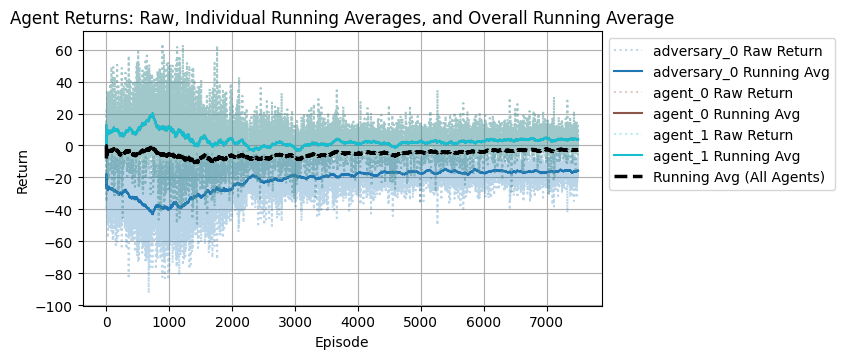

In [8]:
plot_agent_returns(adv_scores_basic)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (700, 700) to (704, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MoviePy - Building file /tmp/rl-video.gif with imageio.


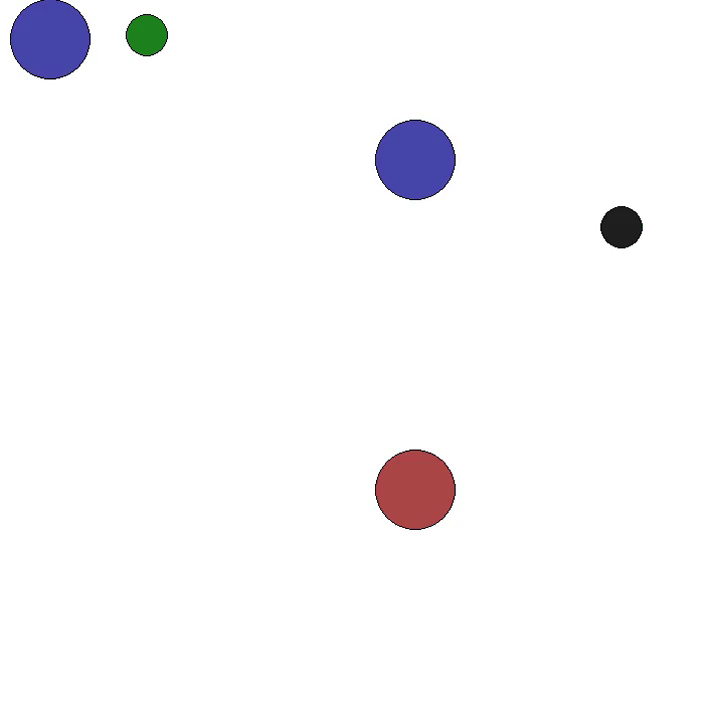

In [ ]:
pettingzoo_simulation(
    simple_adversary_v3,
    agent=agent_adv_basic,
    seed=100,
    wrappers=[simple_adversary_v3_wrappers],
    **MPE_SIMPLE_ADVERSARY_KWARGS
)

### Better strategy

With `30k+` episodes and a different set of hyperparameters, we see how they tend to learn how to
split apart as a better strategy.


In [ ]:
ad_env: AECEnv = create_simple_adversary_env()
ad_env = init_random(ad_env)
agent_ids = ad_env.possible_agents
state_dim = ad_env.observation_space(agent_ids[0]).shape[0]
action_dim = ad_env.action_space(agent_ids[0]).shape[0]

agent_adv_better = MA_DDPG(
    MpeActorNetwork,
    MpeCriticNetwork,
    agent_ids,
    state_dim,
    action_dim,
    action_min=0,
    gamma=0.95,
    min_buffer_size=2048,
    buffer_len=int(3e5),
    batch_size=128,
    update_every=16,
    n_updates=4,
    update_policy_every=2,
    noise_start=1.0,
    noise_reduction=0.99995,
    noise_min=0.25,
)

In [ ]:
# 2h training on GPU. Consider running on CPU given that CPU/GPU communication is bottleneck.
adv_scores_better = train_maddpg(ad_env, agent_adv_better, max_episodes=30_000)

[Episode 25 AVG: -3.968] {'adversary_0': -25.872, 'agent_0': 6.985, 'agent_1': 6.985}               
[Episode 50 AVG: -3.699] {'adversary_0': -26.811, 'agent_0': 7.857, 'agent_1': 7.857}               
[Episode 75 AVG: -3.836] {'adversary_0': -27.039, 'agent_0': 7.765, 'agent_1': 7.765}               
[Episode 100 AVG: -3.314] {'adversary_0': -26.899, 'agent_0': 8.478, 'agent_1': 8.478}              
[Episode 125 AVG: -2.775] {'adversary_0': -28.654, 'agent_0': 10.164, 'agent_1': 10.164}            
[Episode 150 AVG: -3.597] {'adversary_0': -28.832, 'agent_0': 9.020, 'agent_1': 9.020}              
[Episode 175 AVG: -3.924] {'adversary_0': -30.519, 'agent_0': 9.374, 'agent_1': 9.374}              
[Episode 200 AVG: -5.707] {'adversary_0': -32.973, 'agent_0': 7.926, 'agent_1': 7.926}              
[Episode 225 AVG: -7.329] {'adversary_0': -33.735, 'agent_0': 5.874, 'agent_1': 5.874}              
[Episode 250 AVG: -6.431] {'adversary_0': -34.591, 'agent_0': 7.650, 'agent_1': 7.650}     

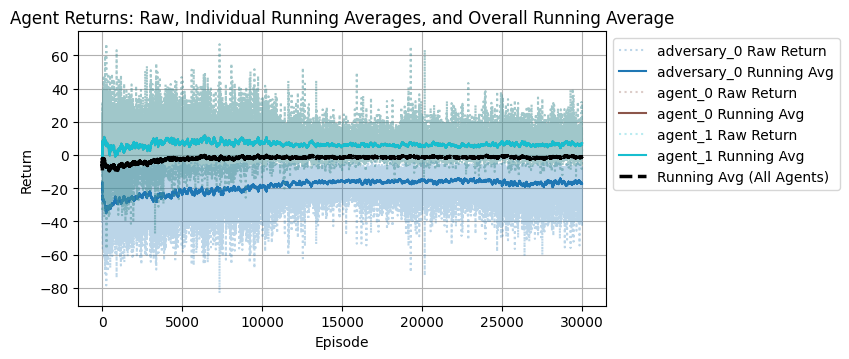

In [12]:
plot_agent_returns(adv_scores_better)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (700, 700) to (704, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MoviePy - Building file /tmp/rl-video.gif with imageio.


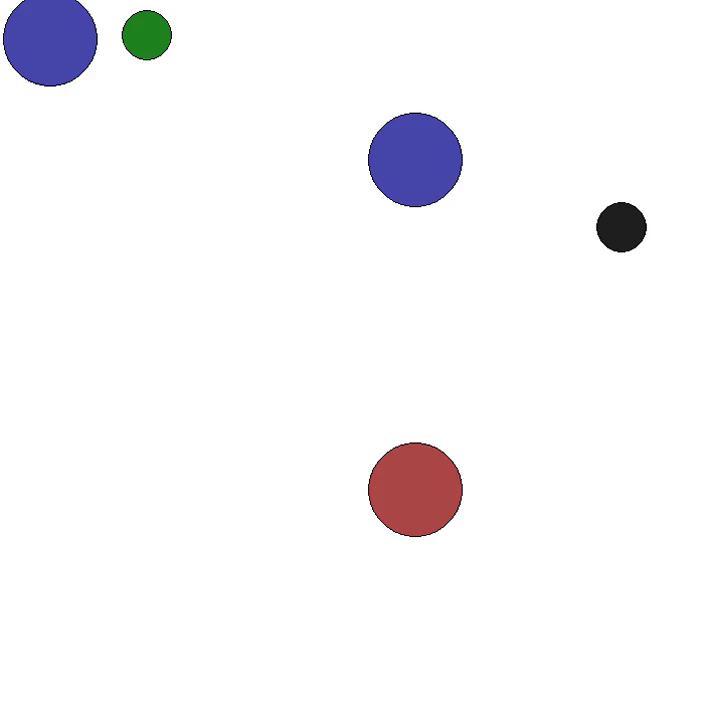

In [ ]:
pettingzoo_simulation(
    simple_adversary_v3,
    agent=agent_adv_better,
    seed=100,
    wrappers=[simple_adversary_v3_wrappers],
    **MPE_SIMPLE_ADVERSARY_KWARGS
)

## Pistonball v6

Pistonball is a "_physics based cooperative game where the goal is to move the ball to the left-wall
of the game border by activating the vertically moving pistons. To achieve an optimal policy for the
environment, pistons must learn highly coordinated behavior_".

Pistonball presents difficulties for MADDPG because coordinating and scaling a large number of
agents with high-dimensional local image observations is complex, and the shared reward structure
makes it hard for the centralized critic to accurately assign credit for collective success or
failure to individual agents, hindering the learning of precise, coordinated actions.


In [ ]:
PISTONBALL_N5 = {
    "n_pistons": 5,
    "max_cycles": 20,
    "time_penalty": -0.3,
}

FRAME_W = 32
FRAME_H = 32


def pistonball_v6_wrappers(zoo_env):
    zoo_env = ss.color_reduction_v0(zoo_env, mode="B")
    zoo_env = ss.resize_v1(zoo_env, FRAME_W, FRAME_H)
    zoo_env = ss.frame_stack_v1(zoo_env, stack_size=3)
    zoo_env = ss.dtype_v0(zoo_env, "uint8")
    return zoo_env


def create_pistonball_env(**env_kwargs):
    zoo_env: AECEnv = pistonball_v6.env(**env_kwargs)
    zoo_env = pistonball_v6_wrappers(zoo_env)
    return zoo_env

In [15]:
test_env: AECEnv = create_pistonball_env()
test_env.reset(seed=42)
agents: list[AgentID] = test_env.agents
print(agents)
print(test_env.action_space(agents[0]))
print(test_env.observation_space(agents[0]))

['piston_0', 'piston_1', 'piston_2', 'piston_3', 'piston_4', 'piston_5', 'piston_6', 'piston_7', 'piston_8', 'piston_9', 'piston_10', 'piston_11', 'piston_12', 'piston_13', 'piston_14', 'piston_15', 'piston_16', 'piston_17', 'piston_18', 'piston_19']
Box(-1.0, 1.0, (1,), float32)
Box(0, 255, (32, 32, 3), uint8)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (280, 560) to (288, 560) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MoviePy - Building file /tmp/rl-video.gif with imageio.


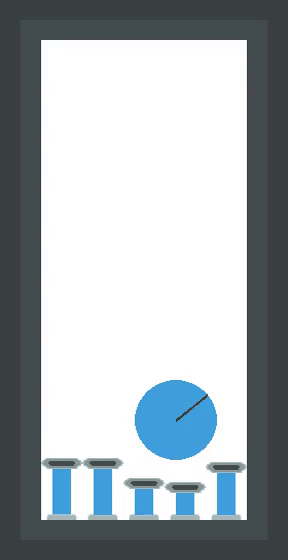

In [16]:
pettingzoo_simulation(pistonball_v6, wrappers=[pistonball_v6_wrappers], **PISTONBALL_N5)

### Pistonball Neural Networks


In [ ]:
FEAT_SIZE = 256
N_STACKED_FRAMES = 3


def convolutional_feature_extractor(output_dim) -> nn.Module:
    return nn.Sequential(
        nn.Conv2d(N_STACKED_FRAMES, 32, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(128 * 4 * 4, output_dim),
        nn.ReLU(),
    )


class PistonballActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.features = convolutional_feature_extractor(FEAT_SIZE)
        self.fc1 = nn.Linear(FEAT_SIZE, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = x.float() / 255.0
        x = x.permute(0, 3, 1, 2)
        x = self.features(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class PistonballCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, num_agents):
        super().__init__()
        self.num_agents = num_agents
        self.critic_input_size = (FEAT_SIZE + action_dim) * num_agents
        self.features = convolutional_feature_extractor(FEAT_SIZE)
        self.fc1 = nn.Linear(self.critic_input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, obs_all_agents, actions_all_agents):
        # action_all_agents shape (n_agents, batch_size, action_dim)
        actions_all_agents = actions_all_agents.permute(1, 0, 2)
        x = obs_all_agents.float() / 255.0
        x = x.permute(1, 0, 4, 2, 3)
        batch_size, num_agents, channels, height, width = x.shape

        x = x.reshape(batch_size * num_agents, channels, height, width)
        x = self.features(x)  # (batch_size * num_agents, feature_size)
        x = x.reshape(batch_size, num_agents, -1)  # (batch_size, num_agents, feature_size)

        x = torch.cat((x, actions_all_agents), dim=2).float().to(DEVICE)
        x = x.flatten(1, 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Training 5 Pistons

In training just 5 pistons, MADDPG converged to a suboptimal policy where the second-to-right-most
piston consistently moves up while the rest remain down. This simple coordinated behavior likely
provides just enough upward force or a consistent bounce point to guide the ball towards the target
zone, resulting in some positive reward. However, this strategy is far from optimal because true
mastery of Pistonball requires dynamic, precise, and coordinated movements from all pistons to
effectively control the ball. This convergence to a local optimum can happen in MADDPG due to the
challenges of credit assignment in shared reward settings; the simple "second piston up" strategy
consistently yields some reward, reinforcing this basic coordination and potentially preventing the
algorithm from exploring and discovering the more complex, highly coordinated behaviors needed for
optimal performance with multiple interacting agents.


In [ ]:
pv6_env: AECEnv = create_pistonball_env(**PISTONBALL_N5)
pv6_env = init_random(pv6_env)
agent_ids = pv6_env.possible_agents
state_dim = pv6_env.observation_space(agent_ids[0]).shape[0]
action_dim = pv6_env.action_space(agent_ids[0]).shape[0]

agent_n5 = MA_DDPG(
    PistonballActorNetwork,
    PistonballCriticNetwork,
    agent_ids,
    state_dim,
    action_dim,
    gamma=0.999,
    min_buffer_size=10_000,
    buffer_len=int(110_000),
    batch_size=128,
    noise_start=1.0,
    noise_reduction=(1.0 - 5e-6),
    noise_min=0.5,
    update_every=32,
    n_updates=8,
    update_policy_every=2,
    lr_actor=1e-5,
    lr_critic=5e-5,
)

In [ ]:
# 8 minutes on GPU.
p5_scores = train_maddpg(pv6_env, agent_n5, max_episodes=1500)

[Episode 25 AVG: 13.810] {'piston_0': 13.810, 'piston_1': 13.810, 'piston_2': 13.810, 'piston_3': 13.810, 'piston_4': 13.810}
[Episode 50 AVG: 24.148] {'piston_0': 24.148, 'piston_1': 24.148, 'piston_2': 24.148, 'piston_3': 24.148, 'piston_4': 24.148}
[Episode 75 AVG: 22.991] {'piston_0': 22.991, 'piston_1': 22.991, 'piston_2': 22.991, 'piston_3': 22.991, 'piston_4': 22.991}
[Episode 100 AVG: 21.809] {'piston_0': 21.809, 'piston_1': 21.809, 'piston_2': 21.809, 'piston_3': 21.809, 'piston_4': 21.809}
[Episode 125 AVG: 23.461] {'piston_0': 23.461, 'piston_1': 23.461, 'piston_2': 23.461, 'piston_3': 23.461, 'piston_4': 23.461}
[Episode 150 AVG: 19.485] {'piston_0': 19.485, 'piston_1': 19.485, 'piston_2': 19.485, 'piston_3': 19.485, 'piston_4': 19.485}
[Episode 175 AVG: 16.796] {'piston_0': 16.796, 'piston_1': 16.796, 'piston_2': 16.796, 'piston_3': 16.796, 'piston_4': 16.796}
[Episode 200 AVG: 17.045] {'piston_0': 17.045, 'piston_1': 17.045, 'piston_2': 17.045, 'piston_3': 17.045, 'piston

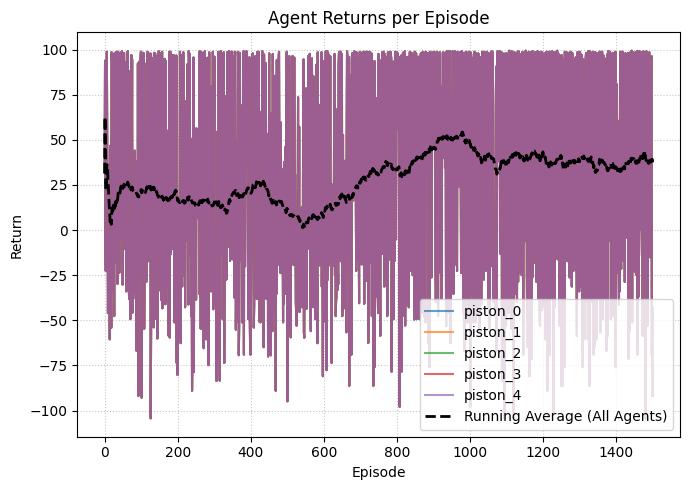

In [ ]:
plot_agent_returns(p5_scores)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (280, 560) to (288, 560) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MoviePy - Building file /tmp/rl-video.gif with imageio.


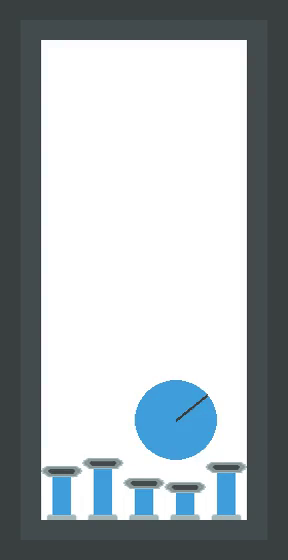

In [ ]:
pettingzoo_simulation(
    pistonball_v6, agent=agent_n5, wrappers=[pistonball_v6_wrappers], **PISTONBALL_N5
)

## MA-PPO

Given the cooperative nature of Pistonball and the need for learning complex, coordinated behaviors
among a significant number of agents with local observations,
[MAPPO](https://arxiv.org/abs/2103.01955) is a well-regarded and often high-performing choice for
cooperative tasks requiring coordinated control

1. **Strong Performance in Cooperative MARL:** MAPPO has demonstrated strong performance on various
   cooperative multi-agent benchmarks, including environments similar to Pistonball.
2. **Stable Training:** As an on-policy algorithm based on PPO, MAPPO tends to have more stable
   training dynamics compared to off-policy methods like MADDPG, which can be prone to instability
   in multi-agent settings. This stability can be crucial for converging to more optimal and complex
   coordinated policies.
3. **Potential for Better Practical Scalability:** While scaling to a very large number of agents
   remains a challenge for most MARL algorithms, MAPPO's improved stability can often translate to
   better performance and more reliable learning compared to MADDPG as the number of agents
   increases, making it potentially more suitable for environments like Pistonball with a moderate
   to large number of participants.
4. **Handles Centralized Training with Decentralized Execution:** Like MADDPG, MAPPO utilizes the
   effective centralized training with decentralized execution paradigm, allowing the critic to
   leverage global information during learning while agents act independently.

Try implementing it! MARL is a rapidly evolving field with other promising algorithms, explore other
popular algorithms as well, like: VDN, QMIX, COMA, independent learning like IQL / IPPO!
